In [1]:
import os
import sys


class TradingBotException(Exception):
    def __init__(self, error_message, error_details: sys):
        self.error_message = error_message
        _, _, exc_tb = error_details.exc_info()
        
        self.lineno = exc_tb.tb_lineno
        self.file_name = exc_tb.tb_frame.f_code.co_filename 
    
    def __str__(self):
        return "Error occured in python script name [{0}] line number [{1}] error message [{2}]".format(
            self.file_name, self.lineno, str(self.error_message)
        ) 
    

In [2]:
    
if __name__ == "__main__":
    try:
        a = 1/0
        print("This will not be printed") 
    except Exception as e:
        raise TradingBotException(e, sys)

TradingBotException: Error occured in python script name [C:\Users\sowmy\AppData\Local\Temp\ipykernel_4972\2222399519.py] line number [3] error message [division by zero]

In [14]:
import logging
import os
from datetime import datetime

# Create 'logs/' directory if it doesn't exist
LOG_DIR = os.path.join(os.getcwd(), "logs")
os.makedirs(LOG_DIR, exist_ok=True)

# Create unique log file name
LOG_FILE = f"{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.log"
LOG_FILE_PATH = os.path.join(LOG_DIR, LOG_FILE)

# Logging configuration
logging.basicConfig(
    filename=LOG_FILE_PATH,
    format="[ %(asctime)s ] %(lineno)d %(name)s - %(levelname)s - %(message)s",
    level=logging.INFO,
)

logger = logging.getLogger("my_agentic_app")

logging.info("hi")

[ 2025-05-13 15:21:49,867 ] 22 root - INFO - hi


In [17]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, AIMessage
from utils.model_loaders import ModelLoader 
from toolkit.tools import *
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver

In [63]:
memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]


class GraphBuilder:
    def __init__(self):
        self.model_loader = ModelLoader()
        self.llm = self.model_loader.load_llm()
        self.tools = [retriever_tool, tavily_tool, financial_tools] 
        llm_with_tools = self.llm.bind_tools(tools=self.tools)
        self.llm_with_tools = llm_with_tools
        self.graph = None
    
    def _chatbot_node(self, state: State):
        return {"messages": [self.llm_with_tools.invoke(state['messages'])]} 
    
    def build(self):
        graph_builder = StateGraph(State) 
        
        graph_builder.add_node("chatbot", self._chatbot_node)
        graph_builder.add_node("tools", ToolNode(self.tools))
        
        graph_builder.add_conditional_edges("chatbot",
                                            tools_condition
                                            )
        graph_builder.add_edge(START, "chatbot")
        graph_builder.add_edge("tools", "chatbot")
        
        self.graph = graph_builder.compile(checkpointer=memory)
        
    def visualize_graph(self, app):
        display(Image(app.get_graph().draw_mermaid_png()))
    
    def get_graph(self):
        if self.graph is None:
            raise ValueError("Graph not built. Call build() first.")
        return self.graph

In [64]:
builder = GraphBuilder()

build = builder.build()
graph = builder.get_graph()

LLM loading...


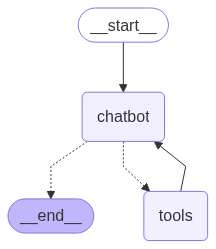

In [65]:
builder.visualize_graph(graph)

In [66]:
config = {"configurable": {"thread_id": 1}}

In [67]:
graph.invoke({"messages": "hi"}, config=config)

Loading embedding model
Loading embedding model


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='b4ab6364-090e-4ae3-bd84-2cdac1f935a2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kx92', 'function': {'arguments': '{"question": "What is the capital of France?"}', 'name': 'retriever_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 457, 'prompt_tokens': 277, 'total_tokens': 734, 'completion_time': 1.701199335, 'prompt_time': 0.019032456, 'queue_time': 0.056287724, 'total_time': 1.720231791}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7731c4e6-b28d-49ff-a7af-b3640fff411e-0', tool_calls=[{'name': 'retriever_tool', 'args': {'question': 'What is the capital of France?'}, 'id': 'call_kx92', 'type': 'tool_call'}], usage_metadata={'input_tokens': 277, 'output_tokens': 457, 'total_tokens': 734}),
  ToolMessage(content="Error: KeyError('sco

In [68]:
messages = "what is the current stock price of adani greens?"

In [46]:
messages = "can you give me a deep knowledge of the stock market?"

In [77]:
result = graph.invoke({"messages": messages}, config=config)

In [78]:
result

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='b4ab6364-090e-4ae3-bd84-2cdac1f935a2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kx92', 'function': {'arguments': '{"question": "What is the capital of France?"}', 'name': 'retriever_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 457, 'prompt_tokens': 277, 'total_tokens': 734, 'completion_time': 1.701199335, 'prompt_time': 0.019032456, 'queue_time': 0.056287724, 'total_time': 1.720231791}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7731c4e6-b28d-49ff-a7af-b3640fff411e-0', tool_calls=[{'name': 'retriever_tool', 'args': {'question': 'What is the capital of France?'}, 'id': 'call_kx92', 'type': 'tool_call'}], usage_metadata={'input_tokens': 277, 'output_tokens': 457, 'total_tokens': 734}),
  ToolMessage(content="Error: KeyError('sco

In [76]:
# for output in graph.stream({"messages": messages}, config=config):
#     print(output)
        

In [79]:
snapshot = graph.get_state(config=config)

In [80]:
snapshot.next

()

In [81]:
current_message = snapshot.values['messages']

In [82]:
current_message

[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='b4ab6364-090e-4ae3-bd84-2cdac1f935a2'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kx92', 'function': {'arguments': '{"question": "What is the capital of France?"}', 'name': 'retriever_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 457, 'prompt_tokens': 277, 'total_tokens': 734, 'completion_time': 1.701199335, 'prompt_time': 0.019032456, 'queue_time': 0.056287724, 'total_time': 1.720231791}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7731c4e6-b28d-49ff-a7af-b3640fff411e-0', tool_calls=[{'name': 'retriever_tool', 'args': {'question': 'What is the capital of France?'}, 'id': 'call_kx92', 'type': 'tool_call'}], usage_metadata={'input_tokens': 277, 'output_tokens': 457, 'total_tokens': 734}),
 ToolMessage(content="Error: KeyError('score_threshold')\

In [83]:
current_message.tool_calls[0]

AttributeError: 'list' object has no attribute 'tool_calls'